<a href="https://colab.research.google.com/github/Harikumarprathip/image-object-detection/blob/main/train_detectron2_segmentation_on_custom_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

**this code is for image detection**
**bold text**





In [ ]:
!nvidia-smi

Tue Jan 16 06:33:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install Detectron2 and dependencies

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-73pygn8k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-73pygn8k
  Resolved https://github.com/facebookresearch/detectron2.git to commit 864913f0e57e87a75c8cc0c7d79ecbd774fc669b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 864.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6119657 sha256=a3f1033e15cd1e2c52df68989c

Now is a good time to confirm that we have the right versions of the libraries at our disposal.

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime
from google.colab.patches import cv2_imshow

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

## Run a Pre-trained Detectron2 Model

Before you start training, it's a good idea to check that everything is working properly. The best way to do this is to perform inference using a pre-trained model.

In [ ]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
image = cv2.imread("/content/object/imagee.jpeg")
cv2_imshow(image)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(image)

model_final_f10217.pkl: 178MB [00:01, 176MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([64, 66, 66, 66,  0,  0, 64, 66, 63, 62, 62, 62, 62,  0, 62, 62,  0, 62,
        56, 63, 64, 66, 66, 62, 56, 62, 66,  0, 56, 66, 62, 66, 63, 63, 56, 62,
        56], device='cuda:0')
Boxes(tensor([[ 863.2374,  799.8255,  930.7578,  836.1147],
        [ 518.9091,  793.3942,  834.4498,  871.0037],
        [ 950.4348,  778.8689, 1228.9330,  842.2289],
        [1209.4589,  759.0367, 1585.1302,  829.0244],
        [1016.5297,  411.0794, 1117.9509,  565.2000],
        [1050.6890,  466.1365, 1211.0334,  601.7832],
        [ 318.4784,  854.6335,  372.6308,  898.4347],
        [   4.1197,  838.6609,  265.1482,  897.3086],
        [ 917.1077,  467.8987, 1029.4569,  537.5163],
        [ 639.2065,  429.2210,  757.2509,  499.5306],
        [ 503.1266,  594.1834,  792.4344,  779.8887],
        [1228.6990,  586.8040, 1435.4917,  746.9608],
        [ 436.2580,  417.0043,  566.2542,  495.9190],
        [  90.0783,  403.2021,  375.1161,  630.6877],
        [ 927.4167,  593.6262, 1152.4474,  767.9

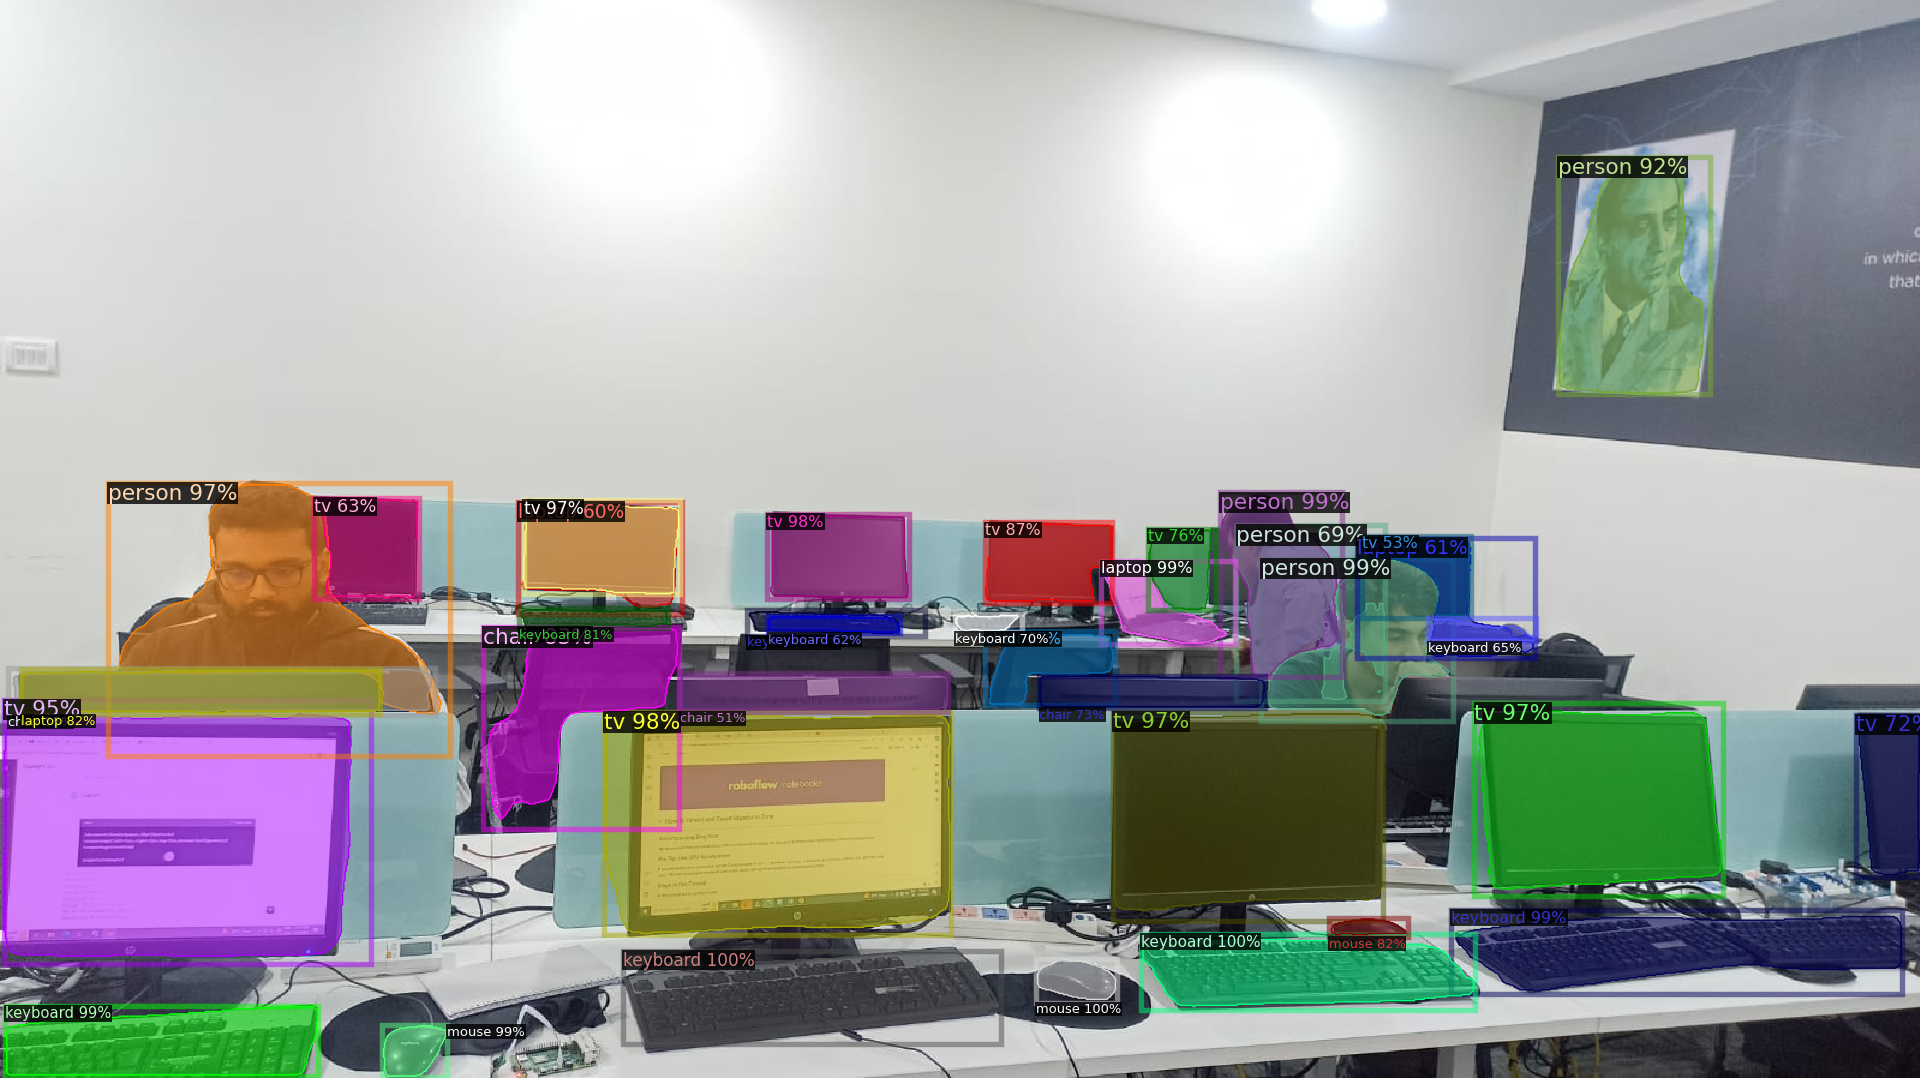

In [ ]:
visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.7/699.7 kB 9.6 MB/s eta 0:00:00


**this code is for image /video segmentation**


WARNING ⚠️ NMS time limit 0.550s exceeded
0: 384x640 2 persons, 3 chairs, 2 tvs, 1 laptop, 160.3ms
Speed: 13.6ms preprocess, 160.3ms inference, 757.3ms postprocess per image at shape (1, 3, 384, 640)


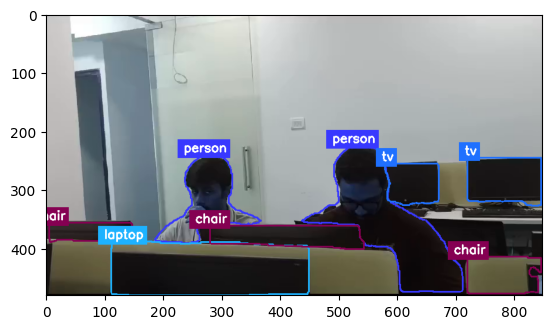


0: 384x640 2 persons, 3 chairs, 2 tvs, 1 laptop, 24.6ms
Speed: 4.8ms preprocess, 24.6ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


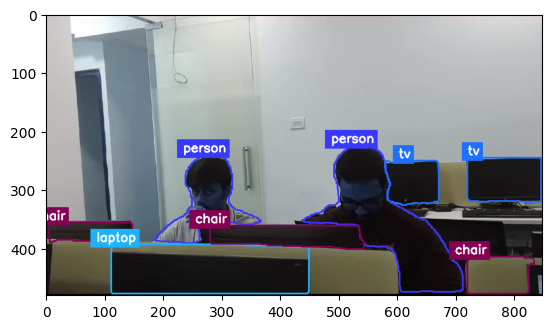


0: 384x640 2 persons, 3 chairs, 2 tvs, 1 laptop, 1 keyboard, 11.7ms
Speed: 2.8ms preprocess, 11.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


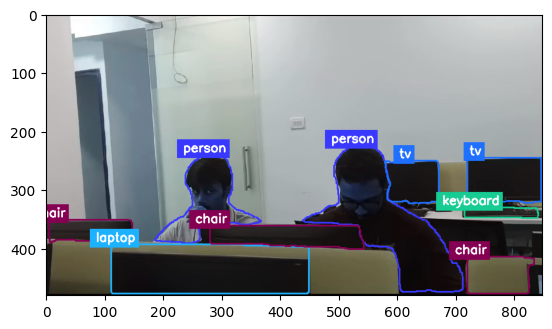


0: 384x640 2 persons, 3 chairs, 2 tvs, 1 laptop, 2 keyboards, 18.2ms
Speed: 3.0ms preprocess, 18.2ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


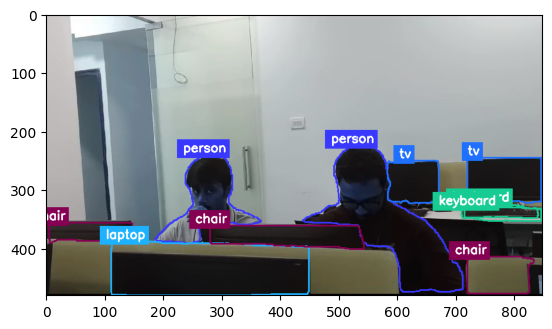


0: 384x640 2 persons, 2 chairs, 2 tvs, 2 laptops, 2 keyboards, 11.5ms
Speed: 2.7ms preprocess, 11.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


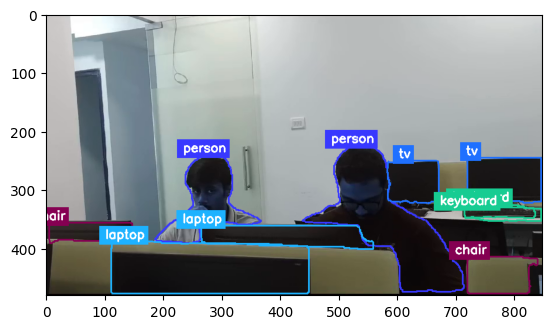


0: 384x640 2 persons, 2 chairs, 2 tvs, 2 laptops, 1 keyboard, 21.0ms
Speed: 8.6ms preprocess, 21.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 2 chairs, 2 tvs, 2 laptops, 1 keyboard, 12.3ms
Speed: 5.4ms preprocess, 12.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 2 persons, 2 chairs, 2 tvs, 2 laptops, 1 keyboard, 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


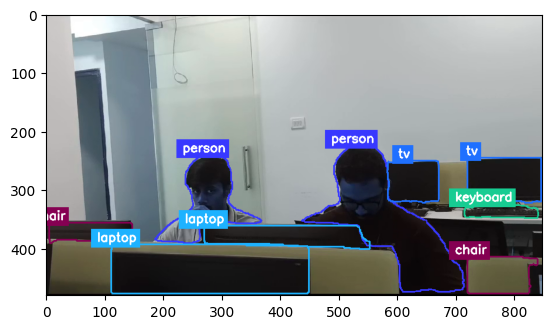


0: 384x640 2 persons, 2 chairs, 2 tvs, 2 laptops, 1 keyboard, 11.7ms
Speed: 2.8ms preprocess, 11.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


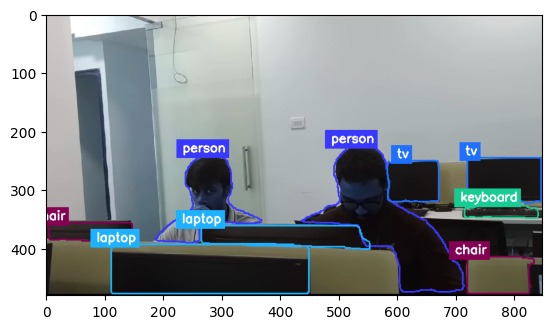


0: 384x640 2 persons, 2 chairs, 2 tvs, 2 laptops, 1 keyboard, 14.4ms
Speed: 3.3ms preprocess, 14.4ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)


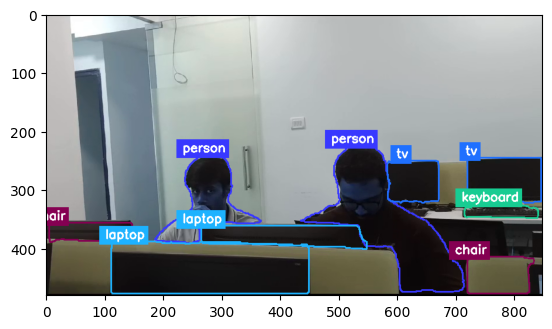


0: 384x640 2 persons, 2 chairs, 2 tvs, 2 laptops, 1 keyboard, 20.1ms
Speed: 2.8ms preprocess, 20.1ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


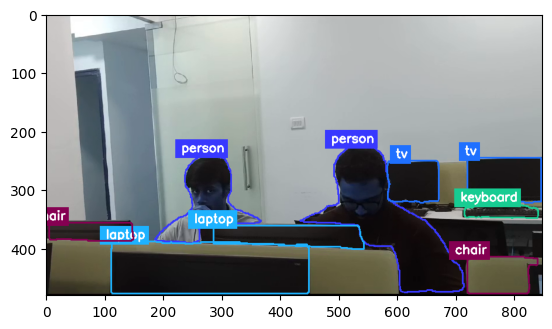


0: 384x640 2 persons, 2 chairs, 2 tvs, 2 laptops, 1 keyboard, 15.2ms
Speed: 2.8ms preprocess, 15.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


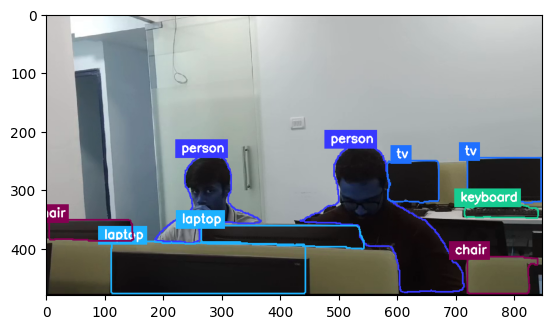


0: 384x640 2 persons, 2 chairs, 2 tvs, 2 laptops, 1 keyboard, 13.6ms
Speed: 2.7ms preprocess, 13.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


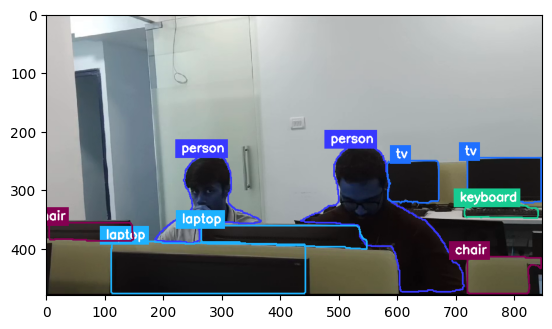


0: 384x640 2 persons, 2 chairs, 2 tvs, 2 laptops, 1 keyboard, 12.1ms
Speed: 3.1ms preprocess, 12.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

# Ensure Matplotlib displays inline
%matplotlib inline

model = YOLO("yolov8n-seg.pt")  # segmentation model
names = model.model.names
cap = cv2.VideoCapture("/content/gpu/segmentation.mp4")
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

# Change the VideoWriter format to MP4
out = cv2.VideoWriter('instance-segmentation.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

while True:
    ret, im0 = cap.read()
    if not ret:
        print("Video frame is empty or video processing has been successfully completed.")
        break

    results = model.predict(im0)
    annotator = Annotator(im0, line_width=2)

    if results[0].masks is not None:
        clss = results[0].boxes.cls.cpu().tolist()
        masks = results[0].masks.xy
        for mask, cls in zip(masks, clss):
            annotator.seg_bbox(mask=mask,
                               mask_color=colors(int(cls), True),
                               det_label=names[int(cls)])

    # Display the annotated image
    plt.imshow(annotator.result())
    plt.show()

    # Write the frame with annotations to the output

**this code is for both video segmentation and tracking **

In [2]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.7/699.7 kB 9.2 MB/s eta 0:00:00


In [3]:
from IPython.display import display
import cv2
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors
from collections import defaultdict

track_history = defaultdict(lambda: [])

model = YOLO("yolov8n-seg.pt")   # segmentation model
cap = cv2.VideoCapture("/content/hari/sample segmentation video.mp4")
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

out = cv2.VideoWriter('instance-segmentation-object-tracking.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

frame_index = 0  # Counter for saving frames as images

while True:
    ret, im0 = cap.read()
    if not ret:
        print("Video frame is empty or video processing has been successfully completed.")
        break

    annotator = Annotator(im0, line_width=2)

    results = model.track(im0, persist=True)

    if results[0].boxes.id is not None and results[0].masks is not None:
        masks = results[0].masks.xy
        track_ids = results[0].boxes.id.int().cpu().tolist()

        for mask, track_id in zip(masks, track_ids):
            annotator.seg_bbox(mask=mask,
                               mask_color=colors(track_id, True),
                               track_label=str(track_id))

    out.write(im0)

    # Save frames as images for display in Colab
    img_path = f'/content/frame_{frame_index}.png'
    cv2.imwrite(img_path, im0)  # Use im0 directly
    frame_index += 1

# Release VideoWriter and VideoCapture
out.release()
cap.release()
cv2.destroyAllWindows()



100%|██████████| 6.73M/6.73M [00:00<00:00, 103MB/s]


requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 10.3s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


WARNING ⚠️ NMS time limit 0.550s exceeded
0: 384x640 2 persons, 1 chair, 1 tv, 152.6ms
Speed: 14.1ms preprocess, 152.6ms inference, 689.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 tv, 10.6ms
Speed: 4.0ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 tv, 17.9ms
Speed: 3.0ms preprocess, 17.9ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 tv, 11.2ms
Speed: 3.0ms preprocess, 11.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 chair, 1 tv, 11.4ms
Speed: 3.2ms p